In [5]:
from scipy.optimize import curve_fit
from functools import wraps
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import scipy
from scipy.stats import chi2

from coffea.util import load

import json
import numpy as np

In [6]:
class HepDataParser:
    """
    A class to parse HEPData JSON files and extract cross sections, errors, 
    and correlation matrices.
    """
    
    def __init__(self):
        pass
        
    @staticmethod
    def parse_cross_section(json_file_path):
        """
        Parses the main cross section JSON file to extract:
        - Bin edges
        - Central values (observed cross section)
        - Statistical errors
        - Systematic errors
        
        Returns:
            dict: Dictionary with 'bins', 'values', 'stat_errors', 'syst_errors'
        """
        with open(json_file_path, 'r') as f:
            data = json.load(f)
        
        result = {'bins': [], 'values': [], 'stat_errors': [], 'syst_errors': []}
        
        for entry in data['values']:
            # Extract bin edges
            bin_low = entry['x'][0]['low']
            bin_high = entry['x'][0]['high']
            result['bins'].append((float(bin_low), float(bin_high)))
            
            # Extract central value
            result['values'].append(float(entry['y'][0]['value']))
            
            # Extract errors
            for error in entry['y'][0]['errors']:
                if error.get('label') == 'stat':
                    result['stat_errors'].append(float(error['symerror']))
                elif error.get('label') == 'syst':
                    result['syst_errors'].append(float(error['symerror']))
        
        # Convert to numpy arrays
        for key in ['values', 'stat_errors', 'syst_errors']:
            result[key] = np.array(result[key])
            
        return result

    @staticmethod
    def parse_correlation_matrix(json_file_path, bins):
        """
        Parses the correlation matrix JSON file and constructs a proper matrix.
        
        Returns:
            np.ndarray: Correlation matrix of shape (n_bins, n_bins)
        """
        with open(json_file_path, 'r') as f:
            data = json.load(f)
        
        # Initialize correlation matrix
        n_bins = len(bins)
        corr_matrix = np.eye(n_bins)
        
        # Create a mapping from bin ranges to indices
        bin_to_index = {}
        for idx, (low, high) in enumerate(bins):
            bin_to_index[(low, high)] = idx
        
        # Fill the correlation matrix from the JSON data
        for entry in data['values']:
            # Get bin ranges from the x values
            x_bins = entry['x']
            bin1 = (float(x_bins[0]['low']), float(x_bins[0]['high']))
            bin2 = (float(x_bins[1]['low']), float(x_bins[1]['high']))
            
            # Get the correlation value and convert from percentage to fraction
            correlation_value = float(entry['y'][0]['value']) / 100.0
            
            # Find the indices for these bins
            if bin1 in bin_to_index and bin2 in bin_to_index:
                i = bin_to_index[bin1]
                j = bin_to_index[bin2]
                corr_matrix[i, j] = correlation_value
                corr_matrix[j, i] = correlation_value  # Symmetric matrix
        
        return corr_matrix
    
    @staticmethod
    def build_covariance_matrix(errors, correlation_matrix):
        """
        Builds covariance matrix from errors and correlation matrix.
        
        Args:
            errors (np.array): Array of errors (statistical or systematic)
            correlation_matrix (np.ndarray): Correlation matrix
            
        Returns:
            np.ndarray: Covariance matrix
        """
        n_bins = len(errors)
        covariance_matrix = np.zeros((n_bins, n_bins))
        
        for i in range(n_bins):
            for j in range(n_bins):
                covariance_matrix[i, j] = errors[i] * errors[j] * correlation_matrix[i, j]
        
        return covariance_matrix
    
    def get_inverse_covariance_matrix(self):
        pt_data = HepDataParser.parse_cross_section("json_files/diff_xsec_photon_pt.json")
        bins_pt = pt_data['bins']
        corr_stat_pt = HepDataParser.parse_correlation_matrix("json_files/stat_corr_pt.json", bins_pt)
        corr_syst_pt = HepDataParser.parse_correlation_matrix("json_files/syst_corr_pt.json", bins_pt)
        V_stat_pt = HepDataParser.build_covariance_matrix(pt_data['stat_errors'], corr_stat_pt)
        V_syst_pt = HepDataParser.build_covariance_matrix(pt_data['syst_errors'], corr_syst_pt)
        V_pt = V_stat_pt + V_syst_pt
        V_pt
        
        deltaphi_data = HepDataParser.parse_cross_section("json_files/deltaphi_ll.json")
        bins_deltaphi = deltaphi_data['bins']
        corr_stat_deltaphi = HepDataParser.parse_correlation_matrix("json_files/stat_corr_deltaphi.json", bins_deltaphi)
        corr_syst_deltaphi = HepDataParser.parse_correlation_matrix("json_files/syst_corr_deltaphi.json", bins_deltaphi)
        V_stat_deltaphi = HepDataParser.build_covariance_matrix(deltaphi_data['stat_errors'], corr_stat_deltaphi)
        V_syst_deltaphi = HepDataParser.build_covariance_matrix(deltaphi_data['syst_errors'], corr_syst_deltaphi)
        V_deltaphi = V_stat_deltaphi + V_syst_deltaphi
        V_deltaphi
        
        # Construct the full data vector and covariance matrix
        # Since cross-observable correlations are not published, we assume block diagonal
        self.y_data = np.concatenate([pt_data['values'], deltaphi_data['values']])
        self.V = scipy.linalg.block_diag(V_pt, V_deltaphi)
        
        # Precompute the inverse covariance matrix for chi2 calculation
        self.V_inv = np.linalg.inv(self.V)
        
        return self.V_inv

In [9]:
class ComputeLimit:
    xsec_TT = 1
    def __init__(self, mass):
        self.output = load("output/output.coffea")
        self.mass = mass

    def compute_prefactor(self, width, coupling):
        return width/(coupling**2)

    def fit_decorator(func):
        @wraps(func)
        def wrapper(self, x, y, **kwarg):
            def fitting_function(x_data, a):
                return func(self, x_data, a)
            return curve_fit(fitting_function, x, y, **kwarg)
        return wrapper

    @fit_decorator
    def fit_prefactor(self, x, a):
        return a * x

    def compute_fiducial_acceptance(self, hist_name, mass):
        dataset = list(self.output["hists"]["total"][hist_name][mass].keys())[0]
        hist = list(self.output["hists"]["total"][hist_name][mass].values())[0]
        values = hist.values()
        xsec = self.output["metadata"][mass][dataset]["xsec"]
        lumi = 138
        
        return values/(xsec * lumi)
    
    def compute_branching_ratios(self, g3g, g3gamma):
        """
        Calculates branching ratios B_g and B_gamma for given couplings.
        This uses the formulas from the paper and the prefactors you calculated.

        Args:
            g3g (float): Dipole coupling to gluons
            g3gamma (float): Dipole coupling to photons

        Returns:
            tuple: (B_g, B_gamma) branching ratios.
        """
        
        ggluon2 = []
        ggamma2 = []
        width_gamma = []
        width_gluon = []
        width_wb = []
        for dataset, metadata in self.output["metadata"][self.mass].items():
            ggluon2.append((metadata["gluonFlag"] * metadata["fvec3"])**2)
            ggamma2.append((metadata["gammaFlag"] * metadata["fvec3"])**2)
            width_gamma.append(metadata["width_T_ta"])
            width_gluon.append(metadata["width_T_tg"])
            width_wb.append(metadata["width_T_wb"])
        
        # Calculate prefactor
        xt = (173.0 / self.mass) ** 2  # xt = (mt / mT)^2
        width_factor = ((self.mass ** 3) / (3000 ** 2)) * (1 - xt) ** 3  # Lambda = 3000 GeV (3 TeV)
        gamma_width_factor = width_factor * np.array(ggamma2)
        gluon_width_factor = width_factor * np.array(ggluon2)
        
        gluon_prefactor = self.fit_prefactor(gluon_width_factor, width_gluon)[0][0]
        gamma_prefactor = self.fit_prefactor(gamma_width_factor, width_gamma)[0][0]
        wb_prefactor = curve_fit(lambda x, a: a * x, ggamma2, width_wb)[0][0]  # width_T_wb = prefactor * fvec3**2 and fvec3 = ggamma/gluonFlag

        Gamma_tg = gluon_prefactor * width_factor * (g3g ** 2)
        Gamma_tgamma = gamma_prefactor * width_factor * (g3gamma ** 2)
        Gamma_wb = wb_prefactor * (g3gamma ** 2)

        # Assuming these are the only decay channels
        Gamma_total = Gamma_tg + Gamma_tgamma + Gamma_wb

        # Calculate Branching Ratios
        B_g = Gamma_tg / Gamma_total
        B_gamma = Gamma_tgamma / Gamma_total

        return B_g, B_gamma
        
    def get_signal_vector(self, g3g, g3gamma):
        """
        Constructs the signal prediction vector s for given couplings.
        (Eq. 7 in the paper)

        Args:
            g3g (float): Dipole coupling to gluons
            g3gamma (float): Dipole coupling to photons

        Returns:
            np.array: Signal vector s (concatenated pT_gamma and DeltaPhi_ll bins)
        """
        # 1. Get the branching ratios
        B_g, B_gamma = self.compute_branching_ratios(g3g, g3gamma)
        f1gamma = 2 * B_gamma * B_g  # Probability for 1 gamma in TTbar event

        # 2. Get the normalized template shapes for a reference coupling (1, 1)
        # The shape is assumed to be independent of the coupling strength, only the normalisation changes.
        # This is a key assumption from the paper (afid is precomputed from MC).
        fiducial_acceptance_pt = self.compute_fiducial_acceptance("diff_xsec_photon_pt", self.mass)
        fiducial_acceptance_deltaphi = self.compute_fiducial_acceptance("deltaphi_ll", self.mass)

        # 3. Calculate the predicted fiducial cross section in each bin
        # sigma_X,i_fid = sigma_pair * f1gamma * a_X,i_fid
        ggluon2 = []
        xsec_TT = []
        for dataset, metadata in self.output["metadata"][self.mass].items():
            ggluon2.append((metadata["gluonFlag"] * metadata["fvec3"])**2)
            xsec_TT.append(metadata["xsec_TT"])
        # sigma_TT = a + b * g3g ** 2 + c * g3g ** 4
        xsec_TT_prefactors = curve_fit(lambda x, a, b, c: a + b * x + c * x **2, ggluon2, xsec_TT)
        sigma_TT = xsec_TT_prefactors[0][0] + xsec_TT_prefactors[0][1] * g3g ** 2 + xsec_TT_prefactors[0][2] * g3g **4
        
        
        s_pT = sigma_TT * f1gamma * fiducial_acceptance_pt
        s_dphi = sigma_TT * f1gamma * fiducial_acceptance_deltaphi

        # 4. Concatenate the vectors to form the full signal prediction
        s_total = np.concatenate([s_pT, s_dphi])
        return s_total
        
    def chi2(self, g3g, g3gamma):
        """
        Calculates the chi2 test statistic for given couplings.
        (Eq. 8 in the paper: s^T V^{-1} s)

        Args:
            g3g (float): Dipole coupling to gluons
            g3gamma (float): Dipole coupling to photons

        Returns:
            float: The chi2 value.
        """
        s_vec = self.get_signal_vector(g3g, g3gamma)
        # The paper assumes the SM is the null hypothesis (data = 0),
        # and s is the NP signal prediction.
        V_inv = HepDataParser().get_inverse_covariance_matrix()
        chi2_val = s_vec @ V_inv @ s_vec
        return chi2_val
    
    def plot(func):
        @wraps(func)
        def wrapper(self, **kwargs):
            X, Y, Z = func(self, **kwargs)
            plt.figure(figsize=(8, 6))
            plt.contourf(X, Y, Z, levels=[chi2.ppf(0.95, df=11), Z.max()], colors=['lightcoral'])
            plt.contour(X, Y, Z, levels=[chi2.ppf(0.95, df=11)], colors='black', linewidths=2)
            
            legend_elements = [
                Patch(facecolor='lightcoral', alpha=0.7, label='$\chi^2 > 5.99$'),
                Line2D([0], [0], color='black', linewidth=2, label='$\chi^2 = 5.99$ (95% CL)')
            ]
            plt.xlabel('$g_{3g}$')
            plt.ylabel('$g_{3\\gamma}$')
            plt.title(f'95% CL Exclusion Contour for mT = {self.mass} GeV')
            plt.legend(handles=legend_elements)
            plt.savefig("plots/limit.png")
            plt.show()
        return wrapper
            
    
    @plot
    def find_contour(self, g3g_range=(-30, 30), g3gamma_range=(-30, 30), n_points=50):
        """
        Scans the (g3g, g3gamma) parameter space and finds the 95% CL contour.

        Args:
            g3g_range (tuple): (min, max) range for g3g scan.
            g3gamma_range (tuple): (min, max) range for g3gamma scan.
            n_points (int): Number of points along each axis.

        Returns:
            tuple: (X, Y, Z) meshgrid arrays and the chi2 values on the grid.
        """
        g3g_vals = np.linspace(g3g_range[0], g3g_range[1], n_points)
        g3gamma_vals = np.linspace(g3gamma_range[0], g3gamma_range[1], n_points)
        G3g, G3gamma = np.meshgrid(g3g_vals, g3gamma_vals)
        Chi2Grid = np.zeros_like(G3g)

        # Calculate chi2 for each point in the grid
        for i, g3g_val in enumerate(g3g_vals):
            for j, g3gamma_val in enumerate(g3gamma_vals):
                # Avoid (0, 0) to prevent division by zero in BR calculation
                if g3g_val == 0 and g3gamma_val == 0:
                    Chi2Grid[j, i] = 0
                else:
                    Chi2Grid[j, i] = self.chi2(g3g_val, g3gamma_val)

        return G3g, G3gamma, Chi2Grid
        

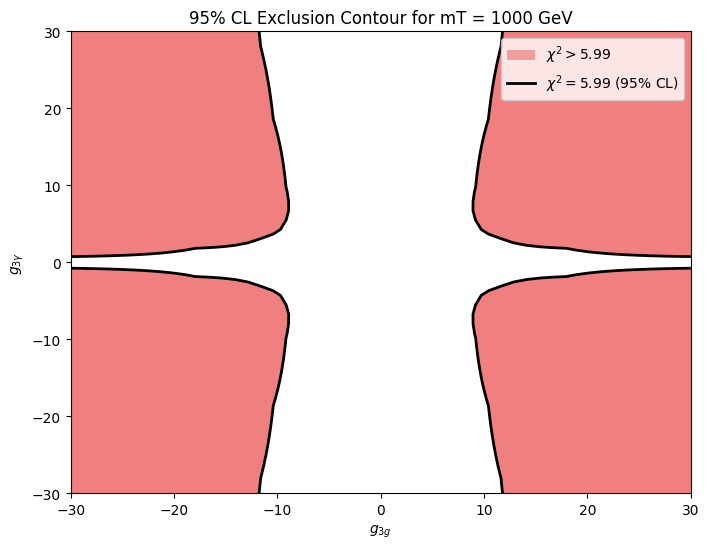

0.0034208505721955

In [10]:
compute_limit = ComputeLimit(1000)
# output = load("output/output.coffea")
# ggluon2 = []
# ggamma2 = []
# width_gamma = []
# width_gluon = []
# for dataset, metadata in output["metadata"][1000].items():
#     ggluon2.append((metadata["gluonFlag"] * metadata["fvec3"])**2)
#     ggamma2.append((metadata["gammaFlag"] * metadata["fvec3"])**2)
#     width_gamma.append(metadata["width_T_ta"])
#     width_gluon.append(metadata["width_T_tg"])

# # Calculate prefactor
# xt = (173.0 / 1000) ** 2  # xt = (mt / mT)^2
# width_factor = ((1000 ** 3) / (3000 ** 2)) * (1 - xt) ** 3  # Lambda = 3000 GeV (3 TeV)
# gamma_width_factor = width_factor * np.array(ggamma2)
# gluon_width_factor = width_factor * np.array(ggluon2)

# gluon_prefactor = compute_limit.fit_prefactor(gluon_width_factor, width_gluon)
# gamma_prefactor = compute_limit.fit_prefactor(gamma_width_factor, width_gamma)
# print(gluon_prefactor[0][0])
# print(gamma_prefactor)

compute_limit.find_contour()
compute_limit.chi2(3, 3)

In [38]:
class ComputeLimit:
    xsec_TT = 1
    def __init__(self, mass):
        self.output = load("output/output.coffea")
        self.mass = mass

    def compute_prefactor(self, width, coupling):
        return width/(coupling**2)

    def fit_decorator(func):
        @wraps(func)
        def wrapper(self, x, y, **kwarg):
            def fitting_function(x_data, a):
                return func(self, x_data, a)
            return curve_fit(fitting_function, x, y, **kwarg)
        return wrapper

    @fit_decorator
    def fit_prefactor(self, x, a):
        return a * x

    def compute_fiducial_acceptance(self, hist_name, mass):
        dataset = list(self.output["hists"]["total"][hist_name][mass].keys())[0]
        hist = list(self.output["hists"]["total"][hist_name][mass].values())[0]
        values = hist.values()
        xsec = self.output["metadata"][mass][dataset]["xsec"]
        lumi = 138
        
        return values/(xsec * lumi)
    
    def compute_branching_ratios(self, g3g, g3gamma):
        """
        Calculates branching ratios B_g and B_gamma for given couplings.
        This uses the formulas from the paper and the prefactors you calculated.

        Args:
            g3g (float): Dipole coupling to gluons
            g3gamma (float): Dipole coupling to photons

        Returns:
            tuple: (B_g, B_gamma) branching ratios.
        """
        
        ggluon2 = []
        ggamma2 = []
        width_gamma = []
        width_gluon = []
        width_wb = []
        for dataset, metadata in self.output["metadata"][self.mass].items():
            ggluon2.append((metadata["gluonFlag"] * metadata["fvec3"])**2)
            ggamma2.append((metadata["gammaFlag"] * metadata["fvec3"])**2)
            width_gamma.append(metadata["width_T_ta"])
            width_gluon.append(metadata["width_T_tg"])
            width_wb.append(metadata["width_T_wb"])
        
        # Calculate prefactor
        # xt = (173.0 / self.mass) ** 2  # xt = (mt / mT)^2
        # width_factor = ((self.mass ** 3) / (3000 ** 2)) * (1 - xt) ** 3  # Lambda = 3000 GeV (3 TeV)
        # gamma_width_factor = width_factor * np.array(ggamma2)/(3000**2)
        # gluon_width_factor = width_factor * np.array(ggluon2)/(3000**2)
        
        gluon_prefactor = self.fit_prefactor(np.array(ggluon2)/(3**2), width_gluon)[0][0]
        gamma_prefactor = self.fit_prefactor(np.array(ggamma2)/(3**2), width_gamma)[0][0]
        wb_prefactor = curve_fit(lambda x, a: a * x, np.array(ggamma2)/(3**2), width_wb)[0][0]  # width_T_wb = prefactor * fvec3**2 and fvec3 = ggamma/gluonFlag

        Gamma_tg = gluon_prefactor * (g3g ** 2)
        Gamma_tgamma = gamma_prefactor * (g3gamma ** 2)
        Gamma_wb = wb_prefactor * (g3gamma ** 2)

        # Assuming these are the only decay channels
        Gamma_total = Gamma_tg + Gamma_tgamma + Gamma_wb

        # Calculate Branching Ratios
        B_g = Gamma_tg / Gamma_total
        B_gamma = Gamma_tgamma / Gamma_total

        return B_g, B_gamma
        
    def get_signal_vector(self, g3g, g3gamma):
        """
        Constructs the signal prediction vector s for given couplings.
        (Eq. 7 in the paper)

        Args:
            g3g (float): Dipole coupling to gluons
            g3gamma (float): Dipole coupling to photons

        Returns:
            np.array: Signal vector s (concatenated pT_gamma and DeltaPhi_ll bins)
        """
        # 1. Get the branching ratios
        B_g, B_gamma = self.compute_branching_ratios(g3g, g3gamma)
        f1gamma = 2 * B_gamma * B_g  # Probability for 1 gamma in TTbar event

        # 2. Get the normalized template shapes for a reference coupling (1, 1)
        # The shape is assumed to be independent of the coupling strength, only the normalisation changes.
        # This is a key assumption from the paper (afid is precomputed from MC).
        fiducial_acceptance_pt = self.compute_fiducial_acceptance("diff_xsec_photon_pt", self.mass)
        fiducial_acceptance_deltaphi = self.compute_fiducial_acceptance("deltaphi_ll", self.mass)

        # 3. Calculate the predicted fiducial cross section in each bin
        # sigma_X,i_fid = sigma_pair * f1gamma * a_X,i_fid
        ggluon2 = []
        xsec_TT = []
        for dataset, metadata in self.output["metadata"][self.mass].items():
            ggluon2.append((metadata["gluonFlag"] * metadata["fvec3"])**2)
            xsec_TT.append(metadata["xsec_TT"])
        # sigma_TT = a + b * g3g ** 2 + c * g3g ** 4
        xsec_TT_prefactors = curve_fit(lambda x, a, b, c: a + b * x + c * x **2, np.array(ggluon2)/(3**2), xsec_TT)
        sigma_TT = xsec_TT_prefactors[0][0] + xsec_TT_prefactors[0][1] * g3g ** 2 + xsec_TT_prefactors[0][2] * g3g **4
        
        sigma_TT_fb = sigma_TT * 1000
        s_pT = sigma_TT_fb * f1gamma * fiducial_acceptance_pt
        s_dphi = sigma_TT_fb * f1gamma * fiducial_acceptance_deltaphi

        # 4. Concatenate the vectors to form the full signal prediction
        s_total = np.concatenate([s_pT, s_dphi])
        return s_total
        
    def chi_square(self, g3g, g3gamma):
        """
        Calculates the chi2 test statistic for given couplings.
        (Eq. 8 in the paper: s^T V^{-1} s)

        Args:
            g3g (float): Dipole coupling to gluons
            g3gamma (float): Dipole coupling to photons

        Returns:
            float: The chi2 value.
        """
        s_vec = self.get_signal_vector(g3g, g3gamma)
        # The paper assumes the SM is the null hypothesis (data = 0),
        # and s is the NP signal prediction.
        V_inv = HepDataParser().get_inverse_covariance_matrix()
        chi2_val = s_vec @ V_inv @ s_vec
        return chi2_val
    
    def plot(func):
        @wraps(func)
        def wrapper(self, chi2_critical=chi2.ppf(0.95, df=11), **kwargs):
            X, Y, Z = func(self, **kwargs)
            plt.figure(figsize=(8, 6))
            plt.contourf(X, Y, Z, levels=[chi2_critical, Z.max()], colors=['lightcoral'])
            plt.contour(X, Y, Z, levels=[chi2_critical], colors='black', linewidths=2)
            
            legend_elements = [
                Patch(facecolor='lightcoral', alpha=0.7, label=f'$\chi^2 > {chi2_critical:.2f}$'),
                Line2D([0], [0], color='black', linewidth=2, label=f'$\chi^2 = {chi2_critical:.2f}$ (95% CL)')
            ]
            plt.xlabel('$g_{3g} (\mathrm{TeV^{-1}})$')
            plt.ylabel('$g_{3\\gamma} (\mathrm{TeV^{-1}})$')
            plt.title(f'95% CL Exclusion Contour for mT = {self.mass} GeV')
            plt.grid()
            plt.legend(handles=legend_elements)
            plt.savefig("plots/limit_landa.png")
            plt.savefig('plots/limit_landa.svg', format='svg', dpi=1200)
            plt.show()
        return wrapper
            
    
    @plot
    def find_contour(self, g3g_range=(-2.5, 2.5), g3gamma_range=(-2.5, 2.5), n_points=150):
        """
        Scans the (g3g, g3gamma) parameter space and finds the 95% CL contour.

        Args:
            g3g_range (tuple): (min, max) range for g3g scan.
            g3gamma_range (tuple): (min, max) range for g3gamma scan.
            n_points (int): Number of points along each axis.

        Returns:
            tuple: (X, Y, Z) meshgrid arrays and the chi2 values on the grid.
        """
        g3g_vals = np.linspace(g3g_range[0], g3g_range[1], n_points)
        g3gamma_vals = np.linspace(g3gamma_range[0], g3gamma_range[1], n_points)
        G3g, G3gamma = np.meshgrid(g3g_vals, g3gamma_vals)
        Chi2Grid = np.zeros_like(G3g)

        # Calculate chi2 for each point in the grid
        for i, g3g_val in enumerate(g3g_vals):
            for j, g3gamma_val in enumerate(g3gamma_vals):
                # Avoid (0, 0) to prevent division by zero in BR calculation
                if g3g_val == 0 and g3gamma_val == 0:
                    Chi2Grid[j, i] = 0
                else:
                    Chi2Grid[j, i] = self.chi_square(g3g_val, g3gamma_val)

        return G3g, G3gamma, Chi2Grid
        

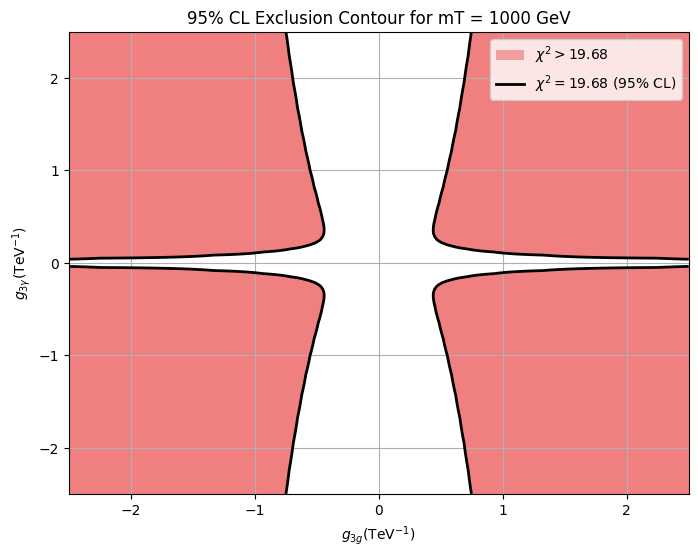

In [39]:
compute_limit = ComputeLimit(1000)
# output = load("output/output.coffea")
# ggluon2 = []
# ggamma2 = []
# width_gamma = []
# width_gluon = []
# for dataset, metadata in output["metadata"][1000].items():
#     ggluon2.append((metadata["gluonFlag"] * metadata["fvec3"])**2)
#     ggamma2.append((metadata["gammaFlag"] * metadata["fvec3"])**2)
#     width_gamma.append(metadata["width_T_ta"])
#     width_gluon.append(metadata["width_T_tg"])

# # Calculate prefactor
# xt = (173.0 / 1000) ** 2  # xt = (mt / mT)^2
# width_factor = ((1000 ** 3) / (3000 ** 2)) * (1 - xt) ** 3  # Lambda = 3000 GeV (3 TeV)
# gamma_width_factor = width_factor * np.array(ggamma2)
# gluon_width_factor = width_factor * np.array(ggluon2)

# gluon_prefactor = compute_limit.fit_prefactor(gluon_width_factor, width_gluon)
# gamma_prefactor = compute_limit.fit_prefactor(gamma_width_factor, width_gamma)
# print(gluon_prefactor[0][0])
# print(gamma_prefactor)

compute_limit.find_contour()

In [32]:
compute_limit.chi_square(-3, -1)

5.071946255293326

In [15]:
ggluon2 = []
ggamma2 = []
width_gamma = []
width_gluon = []
width_wb = []
for dataset, metadata in compute_limit.output["metadata"][compute_limit.mass].items():
    ggluon2.append((metadata["gluonFlag"] * metadata["fvec3"])**2)
    ggamma2.append((metadata["gammaFlag"] * metadata["fvec3"])**2)
    width_gamma.append(metadata["width_T_ta"])
    width_gluon.append(metadata["width_T_tg"])
    width_wb.append(metadata["width_T_wb"])

In [16]:
width_gamma

[36.36084653673702,
 25.250587872734048,
 16.160376238549787,
 9.090211634184255,
 4.040094059637447]

In [17]:
compute_limit.fit_prefactor(np.array(ggamma2), width_gamma)

(array([16.16037624]), array([[1.88716062e-30]]))

In [19]:
compute_limit.fit_prefactor(np.array(ggamma2)/(3**2), width_gamma)

(array([145.44338615]), array([[1.15094599e-28]]))

In [22]:
compute_limit.fit_prefactor(np.array(ggluon2)/(3**2), width_gluon)

(array([193.92451486]), array([[7.19341236e-30]]))

In [23]:
compute_limit.fit_prefactor(np.array(ggamma2)/(3**2), width_wb)

(array([157.60902315]), array([[1.45666602e-28]]))

In [24]:
ggluon2 = []
xsec_TT = []
for dataset, metadata in compute_limit.output["metadata"][compute_limit.mass].items():
    ggluon2.append((metadata["gluonFlag"] * metadata["fvec3"])**2)
    xsec_TT.append(metadata["xsec_TT"])
# sigma_TT = a + b * g3g ** 2 + c * g3g ** 4
xsec_TT_prefactors = curve_fit(lambda x, a, b, c:  a + b * x + c * x **2, np.array(ggluon2)/(3**2), xsec_TT)
xsec_TT_prefactors

(array([0.03244697, 0.1450741 , 1.39018592]),
 array([[ 6.71857878e-09, -1.07601664e-07,  3.37893844e-07],
        [-1.07601664e-07,  2.14198185e-06, -7.30164628e-06],
        [ 3.37893844e-07, -7.30164628e-06,  2.62077838e-05]]))

In [30]:
g = [-1, -0.5, 0, 0.5, 1, 1.5]
sigma = [1.555, 0.1555, 0.03265, 0.1535, 1.551, 7.287]
curve_fit(lambda x, a, b, c: a + b * x**2 + c * x **4, np.array(g)*1000, sigma)

(array([3.09221383e-02, 1.58806875e-07, 1.36275263e-12]),
 array([[ 3.20209573e-06, -6.02675932e-12,  2.09414688e-18],
        [-6.02675932e-12,  1.97679042e-17, -8.03297224e-24],
        [ 2.09414688e-18, -8.03297224e-24,  3.56058954e-30]]))

In [15]:
9 * 0.01611934#, 

0.14507406

In [16]:
(9**2)*0.01716279

1.39018599

In [50]:
np.array(ggluon2)

array([2.25  , 1.5625, 1.    , 0.5625, 0.25  ])

In [51]:
np.array(ggluon2)/(3000**2)

array([2.50000000e-07, 1.73611111e-07, 1.11111111e-07, 6.25000000e-08,
       2.77777778e-08])

In [52]:
2.25 /(3000**2)

2.5e-07

In [46]:
l = [1.000000e+03, 2.0e+03, 3.0e+03]
s = [1.564, 0.1554, 0.06567]
curve_fit(lambda x, b, c: b * x**2 + c * x **4, l, s)

(array([ 3.04589307e-07, -3.40971311e-14]),
 array([[ 3.52087088e-13, -4.10028081e-20],
        [-4.10028081e-20,  5.06079997e-27]]))

In [ ]:
{{-1/3000, 0.06597}, {-0.8/3000, 0.0499}, {-0.6/3000,
    0.04036}, {-0.4/3000, 0.03552}, {-0.2/3000, 0.03292}, {0.1/3000,
    0.03244}, {0.2/3000, 0.03308}, {0.4/3000, 0.03567}, {0.5/3000,
    0.03745}, {0.6/3000, 0.04048}, {0.8/3000, 0.05004}, {1/3000,
    0.06568}}

In [73]:
p = [-1, -0.8, -0.6, -0.4, -0.2, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1]
r = [0.06597, 0.0499, 0.04036, 0.03552, 0.03292, 0.03244, 0.03308, 0.03567, 0.03745, 0.04048, 0.05004, 0.06568]
curve_fit(lambda x, a, b, c: a + b * x**2 + c * x **4, p, r)

(array([0.03232602, 0.0167396 , 0.01677136]),
 array([[ 6.84732377e-09, -2.94872668e-08,  2.35903839e-08],
        [-2.94872668e-08,  2.05463601e-07, -1.88900667e-07],
        [ 2.35903839e-08, -1.88900667e-07,  1.86891317e-07]]))

In [90]:
p = [-1.0/3.0, -0.8/3.0, -0.6/3.0, -0.4/3.0, -0.2/3.0, 0.1/3.0, 0.2/3.0, 0.4/3.0, 0.5/3.0, 0.6/3.0, 0.8/3.0, 1/3.0]
r = [0.06597, 0.0499, 0.04036, 0.03552, 0.03292, 0.03244, 0.03308, 0.03567, 0.03745, 0.04048, 0.05004, 0.06568]
curve_fit(lambda x, a, b, c: a + b * x**2 + c * x **4, np.array(p), np.array(r))

(array([0.03232602, 0.15065637, 1.35848053]),
 array([[ 6.84732253e-09, -2.65385337e-07,  1.91082051e-06],
        [-2.65385337e-07,  1.66425484e-05, -1.37708555e-04],
        [ 1.91082051e-06, -1.37708555e-04,  1.22619363e-03]]))

In [56]:
for degree in [0, 2, 4]:
    coeffs = np.polyfit(p, r, degree)
    poly = np.poly1d(coeffs)

In [57]:
poly

poly1d([ 1.35975036e+12, -8.82325588e+06,  1.50621803e+05,  6.28306141e-01,
        3.23162983e-02])

In [67]:
def f(x):
    return 0.03232602 + 0.0167396 * x**2 + 0.01677136 * x**4
    
f(-0.8)

0.049908913055999996

In [66]:
def f(x):
    return 0.032326 + 150656 * x**2 + 1.35848e12 * x**4
    
f(-0.8/3000)

0.04990886380246914

In [75]:
def f(x):
    return 3.02090537e-02 + 3.03221502e+05 * x**2 + 1.00000000e+00 * x**4
    
f(0.6/3000)

0.0423379137800016

In [77]:
type(p[0])

float

In [79]:
1.0/3000.0

0.0003333333333333333

In [80]:
p

[-0.0003333333333333333,
 -0.0002666666666666667,
 -0.00019999999999999998,
 -0.00013333333333333334,
 -6.666666666666667e-05,
 3.3333333333333335e-05,
 6.666666666666667e-05,
 0.00013333333333333334,
 0.00016666666666666666,
 0.00019999999999999998,
 0.0002666666666666667,
 0.0003333333333333333]

In [88]:
arr = np.array(r)
print(f"NumPy array dtype: {arr.dtype}")

NumPy array dtype: float64


In [86]:
np.array(p)

array([-3.33333333e-04, -2.66666667e-04, -2.00000000e-04, -1.33333333e-04,
       -6.66666667e-05,  3.33333333e-05,  6.66666667e-05,  1.33333333e-04,
        1.66666667e-04,  2.00000000e-04,  2.66666667e-04,  3.33333333e-04])

In [4]:
from scipy.stats import chi2
chi2.ppf(0.95, df=11)

19.67513757268249

In [40]:
98/15

6.533333333333333